In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import pandas as pd
import numpy as np
import string
import gensim
import re
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer 
import itertools
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
from __future__ import print_function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.datasets import fashion_mnist
import keras

Using TensorFlow backend.


In [7]:
## Load data
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

---

## Preprocess

In [8]:
def lemmatize_stemming(text):
    """
    Lemmatize and stem the text
    """
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    '''
    Preprocess the text
    '''
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS :
            result.append(lemmatize_stemming(token))
    return result

In [9]:
# filter html link
train["text"] = train.text.apply(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))
test["text"] = test.text.apply(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

# text preprocessing
train_clean_text = train.text.map(preprocess)
test_clean_text = test.text.map(preprocess)
train["clean_text"] = train_clean_text.apply(lambda x: " ".join(x))
test["clean_text"] = test_clean_text.apply(lambda x: " ".join(x))

In [10]:
clean_keyword = train.keyword.apply(lambda x: " ".join(re.findall("[a-zA-Z]+", str(x))))
train["clean_keyword"] = clean_keyword

---

## Data Visualization

### Distribution of Label

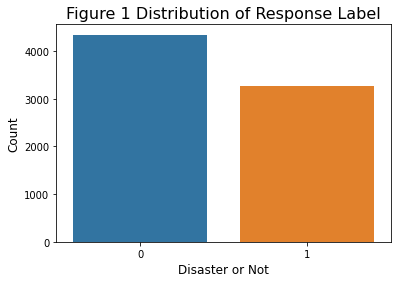

In [11]:
target_count = train.target.value_counts()
sns.barplot(target_count.index, target_count)
plt.xlabel("Disaster or Not", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Figure 1 Distribution of Response Label", fontsize=16)
pass

### Distribution of keywords

The missing rate for keyword is only 0.8%.  

Some common keyword for a real disaster news includes: derailment, wreckage, outbreak, typhoon, oil splil, evacuated, etc.  

Some common keyword for a fake disaster news includes: body bags, armagreddon, harm, ruin, wrecked, deluge, etc.

In [12]:
keyword_na_count = sum(train.keyword.isna())/train.shape[0]
print("The missing rate of keyword is {:2%}".format(keyword_na_count))

The missing rate of keyword is 0.801261%


In [13]:
train_positive = train.loc[(train.target==1) & (train.clean_keyword != "nan")]
train_negative = train.loc[(train.target==0) & (train.clean_keyword != "nan")]

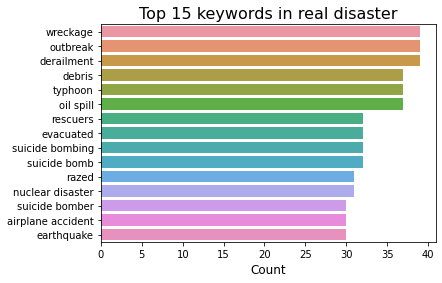

In [14]:
top_keyword_positive = train_positive.clean_keyword.value_counts()[:15]
sns.barplot(y=top_keyword_positive.index, x=top_keyword_positive)
plt.xlabel("Count", fontsize=12)
plt.title("Top 15 keywords in real disaster", fontsize=16)
pass

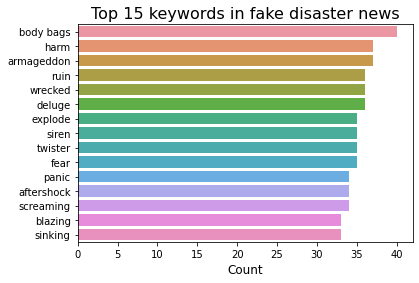

In [15]:
top_keyword_negative = train_negative.clean_keyword.value_counts()[:15]
sns.barplot(y=top_keyword_negative.index, x=top_keyword_negative)
plt.xlabel("Count", fontsize=12)
plt.title("Top 15 keywords in fake disaster news", fontsize=16)
pass

### Distribution of text length 


In [17]:
train["text_len"] = train.clean_text.apply(len)
real_disaster = train.loc[train.target==1]
fake_disaster = train.loc[train.target==0]

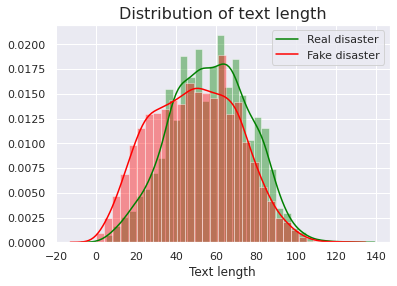

In [18]:
sns.set()
sns.distplot(real_disaster.text_len, color="green",kde_kws={"label":"Real disaster", "color":"green"})
sns.distplot(fake_disaster.text_len, color="red",kde_kws={"label":"Fake disaster", "color":"red"})
plt.xlabel("Text length", fontsize=12)
plt.title("Distribution of text length", fontsize=16)
pass

---

## One-Hot Encoding and fully connect neuro netword

In [19]:
all_text = []
for text in train_clean_text:
    all_text += text

for text in test_clean_text:
    all_text += text

In [20]:
counter = Counter()
for word in all_text:
    counter[word] += 1
    
counter_sort = sorted(counter, key=counter.get, reverse=True)

all_words = counter_sort[:8000]
word_to_id = {word:idx for idx, word in enumerate(all_words)}

In [21]:
def encode_sentence(text, word_to_id):
    '''
    This function applies one-hot encoding to the text.
    It sum up all the vectors in one sentence and then take the average.
    '''
    length = len(word_to_id)
    encode = [0] * length
    if len(text) == 0:
        return encode
    for i in text:
        if i in word_to_id:
            encode[word_to_id[i]] += 1
    return [j/len(text) for j in encode]  

In [22]:
# one-hot encoding
encode_train = pd.Series(train_clean_text).apply(lambda x: encode_sentence(x, word_to_id))
encode_test = pd.Series(test_clean_text).apply(lambda x: encode_sentence(x, word_to_id))

# generate a dataframe for NN
train_df = pd.DataFrame(list(encode_train), columns=list(range(8000)))
test_df = pd.DataFrame(list(encode_test), columns=list(range(8000)))

In [23]:
# split data into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(train_df, train.target, test_size=0.1)
Y_train = keras.utils.to_categorical(Y_train, num_classes=2)
Y_test = keras.utils.to_categorical(Y_test, num_classes=2)

In [24]:
model = Sequential()
model.add(Dense(8000, activation='relu', input_shape=(8000,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation="relu"))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', 
          loss = 'binary_crossentropy', 
          metrics = ['accuracy'])

model.fit(X_train, Y_train, 
          batch_size=256,
          epochs=2,
          validation_data=(X_test, Y_test))

Train on 6851 samples, validate on 762 samples
Epoch 1/2
6851/6851 [==============================] - 3s 474us/sample - loss: 0.5750 - accuracy: 0.6928 - val_loss: 0.4800 - val_accuracy: 0.7782
Epoch 2/2
6851/6851 [==============================] - 1s 104us/sample - loss: 0.3107 - accuracy: 0.8768 - val_loss: 0.5044 - val_accuracy: 0.7913


In [25]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test accuracy", score[1])

Test accuracy 0.79133856


---

## LSTM

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [84]:
vocab_size = 5000
oov_tok = "OOV"
embedding_dim = 8
max_length = 100
trunc_type = "post"
train_size = 0.9

In [85]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train.clean_text)
train_sequence = tokenizer.texts_to_sequences(train.clean_text)
train_padded = pad_sequences(train_sequence, maxlen=max_length, padding="post")

In [86]:
label = train.target

In [87]:
n_row = train.shape[0]
train_index = int(train_size*n_row)
train_data = train_padded[:train_index]
validation_data = train_padded[train_index:]
train_label = label[:train_index]
validation_label = label[train_index:]

In [88]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [89]:
num_epochs=2
model.fit(train_data, train_label, epochs=num_epochs,
         validation_data=(validation_data, validation_label))

Train on 6851 samples, validate on 762 samples
Epoch 1/2
6851/6851 [==============================] - 6s 874us/sample - loss: 0.6340 - accuracy: 0.6272 - val_loss: 0.5303 - val_accuracy: 0.7913
Epoch 2/2
6851/6851 [==============================] - 3s 447us/sample - loss: 0.4032 - accuracy: 0.8305 - val_loss: 0.4402 - val_accuracy: 0.8163
